# Multi-Class Classification Model for Crop Mapping in Canada Using Scikit-Learn Take 4
### David Lowe
### July 16, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Crop Mapping in Canada dataset is a multi-class classification situation where we are trying to predict one of several (more than two) possible outcomes.

INTRODUCTION: This data set is a fused bi-temporal optical-radar data for cropland classification. The organization collected the images using RapidEye satellites (optical) and the Unmanned Aerial Vehicle Synthetic Aperture Radar (UAVSAR) system (Radar) over an agricultural region near Winnipeg, Manitoba, Canada in 2012. There are 2 * 49 radar features and 2 * 38 optical features for two dates: 05 and 14 July 2012. Seven crop type classes exist for this data set as follows: 1-Corn; 2-Peas; 3-Canola; 4-Soybeans; 5-Oats; 6-Wheat; and 7-Broadleaf.

In iteration Take1, we constructed and tuned machine learning models for this dataset using the Scikit-Learn library. We also observed the best accuracy result that we could obtain using the tuned model with the training and test datasets.

In iteration Take2, we made a slight modification to the Take1 experiment by creating an intermediate dataset for validating the models after training. Furthermore, we observed the best accuracy result that we could obtain using the tuned model with the set-aside test dataset

In iteration Take3, we constructed and tuned machine learning models for this dataset using the XGBoost library. We also observed the best accuracy result that we could obtain using the tuned model with the training and test datasets.

In this Take4 iteration, we will make a slight modification to the Take3 experiment by creating an intermediate dataset for validating the models after training. Furthermore, we will observe the best accuracy result that we can obtain using the tuned model with the set-aside test dataset.

ANALYSIS: From iteration Take1, the performance of the machine learning algorithms achieved a baseline average accuracy of 99.24%. Two algorithms (Extra Trees and k-Nearest Neighbors) achieved the top accuracy metrics after the first round of modeling. After a series of tuning trials, the Extra Trees model processed the training dataset with an accuracy score of 99.72%. When configured with the optimized parameters, the Extra Trees model processed the test dataset with an accuracy score of 99.74%, which was consistent with the prediction from the training dataset.

From iteration Take2, the performance of the machine learning algorithms achieved a baseline average accuracy of 99.18%. Two algorithms (Extra Trees and k-Nearest Neighbors) achieved the top accuracy metrics after the first round of modeling. After a series of tuning trials, the Extra Trees model processed the validation dataset with an accuracy score of 99.72%. When configured with the optimized parameters, the Extra Trees model processed the test dataset with an accuracy score of 99.74%, which was consistent with the prediction results from the training and validation phases.

From iteration Take3, the performance of the XGBoost model achieved an accuracy score of 99.83%. After a series of tuning trials, the XGBoost model processed the test dataset with an accuracy score of 99.83%, which was consistent with the prediction results from the training phase.

From this Take4 iteration, the performance of the XGBoost model achieved an accuracy score of 99.79% with the training dataset. After a series of tuning trials, the XGBoost model processed the validation dataset with an accuracy score of 99.80%, which was consistent with the prediction from the training result. When configured with the optimized parameters, the XGBoost model processed the test dataset with an accuracy score of 99.84%, which was consistent with the prediction results from the training and validation phases.

CONCLUSION: For this iteration, the XGBoost model achieved the best overall results using the training and test datasets. For this dataset, we should consider using the XGBoost algorithm for further modeling.

Dataset Used: Crop Mapping in Canada Data Set

Dataset ML Model: Multi-Class classification with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/Crop+mapping+using+fused+optical-radar+data+set

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
!pip install python-dotenv PyMySQL

     |████████████████████████████████| 51kB 3.2MB/s 


In [2]:
# Retrieve the GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Mon Jul 13 18:39:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
seedNum = 888

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import math
import boto3
from datetime import datetime
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useGDrive = False
if useGDrive:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", 500)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set the number of folds for cross validation
n_folds = 5

# Set various default modeling parameters
scoring = 'accuracy'

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None) or (topic_arn is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if notifyStatus: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/crop-mapping-winnipeg/WinnipegDataset.txt'
Xy_original = pd.read_csv(dataset_path)

# Take a peek at the dataframe after import
Xy_original.head(10)

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
0,1,-13.559,-21.407,-11.4040,-15.248,-11.923,-15.291,-2.1548,-7.8474,-10.0020,0.04239,3.3253,3.3677,0.35631,0.058490,0.58520,0.24150,0.51934,0.23916,-0.62424,-0.81493,-0.70844,-0.65641,-0.19568,-0.63160,0.091945,0.026703,0.005017,0.62019,0.68370,44.369,0.42402,0.19617,0.25967,0.12013,0.054561,0.16226,-11.923,-12.823,-21.407,...,0.13580,0.650770,6711,6143,4570,5064,8212,0.28493,1.7969,1.3442,-0.61941,0.54346,0.42738,0.14683,0.144130,0.58593,0.23712,1.6216,0.23712,294110.0,0.051277,2199.4,92560.0,1.1081,48.444,3.13580,0.57778,2.44440,1.11110,1.8310,0.18519,0.72602,5.3333,6.000000,0.29489,9.77780,2.44440,1.67700,0.20988,0.65422
1,1,-12.802,-20.335,-10.3990,-14.132,-11.096,-14.361,-2.4039,-7.5330,-9.9369,0.22842,3.0360,3.2644,0.34295,0.060525,0.59652,0.25249,0.50796,0.23955,-0.57229,-0.74854,-0.64839,-0.62810,-0.18825,-0.55448,0.115710,0.031183,0.006051,0.60356,0.67496,44.992,0.40738,0.19618,0.26758,0.12886,0.052298,0.15826,-11.096,-11.805,-20.335,...,0.30864,0.104830,6274,5084,3297,3777,8214,0.42716,2.4914,1.5420,-0.64500,0.92501,0.64071,0.21322,0.235370,0.75089,0.37003,2.1747,0.37003,412400.0,0.067854,2338.4,100280.0,1.1456,49.778,0.39506,0.46667,1.33330,1.11110,1.2149,0.33333,-0.48751,2.1111,0.098765,0.83333,0.33333,0.33333,0.84869,0.50617,-0.18898
2,1,-12.431,-19.902,-10.0740,-13.598,-10.829,-14.048,-2.3566,-7.4717,-9.8283,0.44978,2.7687,3.2185,0.34489,0.061731,0.59338,0.26362,0.49870,0.23768,-0.53347,-0.70253,-0.58846,-0.61836,-0.17804,-0.48642,0.127130,0.032382,0.006162,0.58683,0.68024,45.466,0.39919,0.18764,0.28105,0.13211,0.048473,0.14878,-10.829,-11.377,-19.902,...,0.30864,0.613940,6215,5035,3033,3837,8588,0.47801,2.8315,1.6601,-0.70049,1.03530,0.71699,0.24814,0.260810,0.80946,0.38237,2.2382,0.38237,439570.0,0.117030,3321.3,128320.0,1.2651,49.444,0.24691,0.61111,0.77778,0.77778,1.3689,0.25926,0.25298,2.2222,0.172840,0.68889,0.88889,0.66667,1.27300,0.30864,0.10483
3,1,-12.689,-19.529,-10.0280,-13.350,-11.056,-14.014,-2.6611,-6.8396,-9.5006,0.66378,2.2942,2.9580,0.32760,0.067825,0.60457,0.28135,0.47717,0.24148,-0.50405,-0.66998,-0.52543,-0.61169,-0.17507,-0.43576,0.127200,0.031091,0.006040,0.57769,0.67468,46.654,0.38976,0.18793,0.28492,0.13738,0.047480,0.14701,-11.056,-11.263,-19.529,...,0.16049,0.064018,6836,5745,4212,4534,7691,0.29228,1.8260,1.3640,-0.47512,0.65772,0.43840,0.15396,0.144830,0.60147,0.25824,1.6963,0.25824,296240.0,0.036817,1748.1,80640.0,1.0764,50.667,0.88889,0.61111,0.77778,0.77778,1.8892,0.16049,0.43750,4.1111,0.320990,0.83333,0.33333,0.33333,1.14910,0.38272,0.41603
4,1,-12.686,-19.278,-9.8185,-13.108,-10.932,-13.939,-2.8675,-6.5919,-9.4594,0.83143,2.1756,3.0070,0.31701,0.069483,0.61351,0.28768,0.47476,0.23756,-0.50314,-0.68221,-0.50731,-0.59134,-0.17505,-0.45195,0.131550,0.031960,0.006439,0.57937,0.66460,46.828,0.38505,0.19432,0.27955,0.14108,0.048950,0.15156,-10.932,-11.109,-19.278,...,0.20988,0.657600,6682,5883,4434,4627,7072,0.22927,1.5949,1.3268,-0.40120,0.52776,0.34389,0.14045,0.091779,0.53551,0.20899,1.5284,0.20899,232610.0,0.021300,1365.4,69540.0,1.0435,51.222,0.39506,0.56667,1.66670,1.00000,1.7351,0.18519,0.35000,4.0000,0.444440,0.68889,0.88889,0.66667,1.58110,0.20988,0.50000
5,1,-12.478,-19.034,-9.6201,-12.888,-10.761,-13.687,-2.8583,-6.5555,-9.4138,0.79854,2.1276,2.9261,0.31723,0.070118,0.61265,0.28867,0.47115,0.24018,-0.49984,-0.69457,-0.50160,-0.58093,-0.17393,-0.45870,0.138010,0.033254,0.006886,0.57967,0.65689,47.061,0.38078,0.19889,0.27611,0.14422,0.049898,0.15462,-10.761,-10.877,-19.034,...,0.30864,0.316230,6424,5297,3248,3956,8504,0.44724,2.6182,1.6308,-0.65091,0.98321,0.67084,0.23979,0.232370,0.79120,0.36501,2.1496,0.36501,422730.0,0.09

In [11]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325834 entries, 0 to 325833
Data columns (total 175 columns):
 #   Column  Dtype  
---  ------  -----  
 0   label   int64  
 1   f1      float64
 2   f2      float64
 3   f3      float64
 4   f4      float64
 5   f5      float64
 6   f6      float64
 7   f7      float64
 8   f8      float64
 9   f9      float64
 10  f10     float64
 11  f11     float64
 12  f12     float64
 13  f13     float64
 14  f14     float64
 15  f15     float64
 16  f16     float64
 17  f17     float64
 18  f18     float64
 19  f19     float64
 20  f20     float64
 21  f21     float64
 22  f22     float64
 23  f23     float64
 24  f24     float64
 25  f25     float64
 26  f26     float64
 27  f27     float64
 28  f28     float64
 29  f29     float64
 30  f30     float64
 31  f31     float64
 32  f32     float64
 33  f33     float64
 34  f34     float64
 35  f35     float64
 36  f36     float64
 37  f37     float64
 38  f38     float64
 39  f39     float64
 40  f

In [12]:
Xy_original.describe()

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
count,325834.000000,325834.000000,325834.000000,325834.000000,325834.00000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,...,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,3.258340e+05,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000
mean,4.062421,-15.143602,-24.026035,-15.400034,-18.59383,-14.493472,-18.427329,0.256432,-8.882434,-8.626002,-0.166500,4.100357,3.933857,0.480376,0.064088,0.455535,0.217800,0.555515,0.226686,-1.517263,-1.608698,-1.181434,-1.592702,-0.308595,-1.486840,0.057962,0.025120,0.005054,0.715467,0.702775,41.669169,0.500494,0.214973,0.202282,0.082251,0.083237,0.209597,-14.493472,-16.190682,-24.026035,...,0.669702,0.535537,6155.009207,5429.189523,3224.350943,4651.873460,10335.963905,0.512992,3.302018,1.708508,-1.165913,0.949212,0.769460,0.258010,0.300439,0.810907,0.371572,2.235246,0.371572,5.193413e+05,0.181069,4939.284233,173844.894271,1.458607,44.453234,0.480385,0.755551,0.929868,0.553554,1.074719,0.433834,0.329085,2.171177,0.080138,0.919604,0.174447,0.162900,0.403288,0.764646,0.667567
std,1.604617,3.504255,4.054214,3.267857,3.71163,3.189013,3.675741,1.682060,1.204040,2.002658,0.596276,1.499603,1.539068,0.083552,0.020465,0.093410,0.041863,0.082040,0.045401,0.644197,0.621884,0.519517,0.668061,0.155145,0.635231,0.054490,0.020026,0.005420,0.067356,0.105147,5.775659,0.076198,0.087860,0.060233,0.030058,0.037619,0.084197,3.189013,3.663707,4.054214,...,0.286678,0.500804,245.682028,582.646612,572.939182,746.884339,2262.583966,0.117465,0.868576,0.180011,1.969942,0.186985,0.176194,0.054244,0.090148,0.126551,0.084858,0.399870,0.084858,1.699188e+05,0.066900,1758.170529,54569.523161,0.202670,5.066352,1.263675,0.165313,2.121463,0.490840,0.541818,0.245857,0.442008,1.284653,0.182628,0.105953,0.373726,0.222008,0.480141,0.273847,0.471260
min,1.000000,-23.971000,-34.308000,-23.161000,-27.24500,-22.103000,-26.897000,-5.582600,-16.389000,-16.558000,-2.717500,-4.281900,-4.498300,0.209190,0.015586,0.162270,0.064580,0.153900,0.075863,-6.793300,-7.756700,-7.643300,-7.676600,-2.051400,-7.383900,0.006389,0.003183,0.000264,0.307150,0.145010,17.538000,0.101970,0.020272,0.023803,0.010547,0.007286,0.021641,-22.103000,-24.520000,-34.308000,...,0.111110,-1.000000,5495.000000,4310.000000,2219.000000,2462.000000,3050.000000,-0.100680,0.817050,1.030300,-502.770000,0.003170,-0.151020,0.014904,-0.272750,-0.035341,-0.019756,0.961250,-0.019756,6.390000e+03,-0.104300,-4178.200000,-45280.000000,0.811110,27.000000,0.000000,0.027761,0.000000,0.000000,-0.000000,0.111110,-1.000000,0.000000,0.000000,0.106190,0.000000,0.000000,-0.000000,0.111110,-1.000000
25%,3.000000,-17.848000,-27.119000,-17.563000,-21.44900,-16.989000,-21.450000,-1.037800,-9.658500,-10.070000,-0.526397,3.141300,2.933200,0.415260,0.048986,0.382610,0.189580,0.

In [13]:
Xy_original.isnull().sum()

label    0
f1       0
f2       0
f3       0
f4       0
f5       0
f6       0
f7       0
f8       0
f9       0
f10      0
f11      0
f12      0
f13      0
f14      0
f15      0
f16      0
f17      0
f18      0
f19      0
f20      0
f21      0
f22      0
f23      0
f24      0
f25      0
f26      0
f27      0
f28      0
f29      0
f30      0
f31      0
f32      0
f33      0
f34      0
f35      0
f36      0
f37      0
f38      0
f39      0
f40      0
f41      0
f42      0
f43      0
f44      0
f45      0
f46      0
f47      0
f48      0
f49      0
f50      0
f51      0
f52      0
f53      0
f54      0
f55      0
f56      0
f57      0
f58      0
f59      0
f60      0
f61      0
f62      0
f63      0
f64      0
f65      0
f66      0
f67      0
f68      0
f69      0
f70      0
f71      0
f72      0
f73      0
f74      0
f75      0
f76      0
f77      0
f78      0
f79      0
f80      0
f81      0
f82      0
f83      0
f84      0
f85      0
f86      0
f87      0
f88      0
f89      0
f90      0

In [14]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [15]:
# Standardize the class column to the name of targetVar if required
Xy_original = Xy_original.rename(columns={'label': 'targetVar'})

# Convert columns from one data type to another
Xy_original['f137'] = Xy_original['f137'].astype('float')
Xy_original['f138'] = Xy_original['f138'].astype('float')
Xy_original['f139'] = Xy_original['f139'].astype('float')
Xy_original['f140'] = Xy_original['f140'].astype('float')
Xy_original['f141'] = Xy_original['f141'].astype('float')

# Take a peek at the dataframe after cleaning
Xy_original.head(10)

,targetVar,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
0,1,-13.559,-21.407,-11.4040,-15.248,-11.923,-15.291,-2.1548,-7.8474,-10.0020,0.04239,3.3253,3.3677,0.35631,0.058490,0.58520,0.24150,0.51934,0.23916,-0.62424,-0.81493,-0.70844,-0.65641,-0.19568,-0.63160,0.091945,0.026703,0.005017,0.62019,0.68370,44.369,0.42402,0.19617,0.25967,0.12013,0.054561,0.16226,-11.923,-12.823,-21.407,...,0.13580,0.650770,6711.0,6143.0,4570.0,5064.0,8212.0,0.28493,1.7969,1.3442,-0.61941,0.54346,0.42738,0.14683,0.144130,0.58593,0.23712,1.6216,0.23712,294110.0,0.051277,2199.4,92560.0,1.1081,48.444,3.13580,0.57778,2.44440,1.11110,1.8310,0.18519,0.72602,5.3333,6.000000,0.29489,9.77780,2.44440,1.67700,0.20988,0.65422
1,1,-12.802,-20.335,-10.3990,-14.132,-11.096,-14.361,-2.4039,-7.5330,-9.9369,0.22842,3.0360,3.2644,0.34295,0.060525,0.59652,0.25249,0.50796,0.23955,-0.57229,-0.74854,-0.64839,-0.62810,-0.18825,-0.55448,0.115710,0.031183,0.006051,0.60356,0.67496,44.992,0.40738,0.19618,0.26758,0.12886,0.052298,0.15826,-11.096,-11.805,-20.335,...,0.30864,0.104830,6274.0,5084.0,3297.0,3777.0,8214.0,0.42716,2.4914,1.5420,-0.64500,0.92501,0.64071,0.21322,0.235370,0.75089,0.37003,2.1747,0.37003,412400.0,0.067854,2338.4,100280.0,1.1456,49.778,0.39506,0.46667,1.33330,1.11110,1.2149,0.33333,-0.48751,2.1111,0.098765,0.83333,0.33333,0.33333,0.84869,0.50617,-0.18898
2,1,-12.431,-19.902,-10.0740,-13.598,-10.829,-14.048,-2.3566,-7.4717,-9.8283,0.44978,2.7687,3.2185,0.34489,0.061731,0.59338,0.26362,0.49870,0.23768,-0.53347,-0.70253,-0.58846,-0.61836,-0.17804,-0.48642,0.127130,0.032382,0.006162,0.58683,0.68024,45.466,0.39919,0.18764,0.28105,0.13211,0.048473,0.14878,-10.829,-11.377,-19.902,...,0.30864,0.613940,6215.0,5035.0,3033.0,3837.0,8588.0,0.47801,2.8315,1.6601,-0.70049,1.03530,0.71699,0.24814,0.260810,0.80946,0.38237,2.2382,0.38237,439570.0,0.117030,3321.3,128320.0,1.2651,49.444,0.24691,0.61111,0.77778,0.77778,1.3689,0.25926,0.25298,2.2222,0.172840,0.68889,0.88889,0.66667,1.27300,0.30864,0.10483
3,1,-12.689,-19.529,-10.0280,-13.350,-11.056,-14.014,-2.6611,-6.8396,-9.5006,0.66378,2.2942,2.9580,0.32760,0.067825,0.60457,0.28135,0.47717,0.24148,-0.50405,-0.66998,-0.52543,-0.61169,-0.17507,-0.43576,0.127200,0.031091,0.006040,0.57769,0.67468,46.654,0.38976,0.18793,0.28492,0.13738,0.047480,0.14701,-11.056,-11.263,-19.529,...,0.16049,0.064018,6836.0,5745.0,4212.0,4534.0,7691.0,0.29228,1.8260,1.3640,-0.47512,0.65772,0.43840,0.15396,0.144830,0.60147,0.25824,1.6963,0.25824,296240.0,0.036817,1748.1,80640.0,1.0764,50.667,0.88889,0.61111,0.77778,0.77778,1.8892,0.16049,0.43750,4.1111,0.320990,0.83333,0.33333,0.33333,1.14910,0.38272,0.41603
4,1,-12.686,-19.278,-9.8185,-13.108,-10.932,-13.939,-2.8675,-6.5919,-9.4594,0.83143,2.1756,3.0070,0.31701,0.069483,0.61351,0.28768,0.47476,0.23756,-0.50314,-0.68221,-0.50731,-0.59134,-0.17505,-0.45195,0.131550,0.031960,0.006439,0.57937,0.66460,46.828,0.38505,0.19432,0.27955,0.14108,0.048950,0.15156,-10.932,-11.109,-19.278,...,0.20988,0.657600,6682.0,5883.0,4434.0,4627.0,7072.0,0.22927,1.5949,1.3268,-0.40120,0.52776,0.34389,0.14045,0.091779,0.53551,0.20899,1.5284,0.20899,232610.0,0.021300,1365.4,69540.0,1.0435,51.222,0.39506,0.56667,1.66670,1.00000,1.7351,0.18519,0.35000,4.0000,0.444440,0.68889,0.88889,0.66667,1.58110,0.20988,0.50000
5,1,-12.478,-19.034,-9.6201,-12.888,-10.761,-13.687,-2.8583,-6.5555,-9.4138,0.79854,2.1276,2.9261,0.31723,0.070118,0.61265,0.28867,0.47115,0.24018,-0.49984,-0.69457,-0.50160,-0.58093,-0.17393,-0.45870,0.138010,0.033254,0.006886,0.57967,0.65689,47.061,0.38078,0.19889,0.27611,0.14422,0.049898,0.15462,-10.761,-10.877,-19.034,...,0.30864,0.316230,6424.0,5297.0,3248.0,3956.0,8504.0,0.44724,2.6182,1.6308,-0.65091,0.98321,0.670

In [16]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325834 entries, 0 to 325833
Data columns (total 175 columns):
 #   Column     Dtype  
---  ------     -----  
 0   targetVar  int64  
 1   f1         float64
 2   f2         float64
 3   f3         float64
 4   f4         float64
 5   f5         float64
 6   f6         float64
 7   f7         float64
 8   f8         float64
 9   f9         float64
 10  f10        float64
 11  f11        float64
 12  f12        float64
 13  f13        float64
 14  f14        float64
 15  f15        float64
 16  f16        float64
 17  f17        float64
 18  f18        float64
 19  f19        float64
 20  f20        float64
 21  f21        float64
 22  f22        float64
 23  f23        float64
 24  f24        float64
 25  f25        float64
 26  f26        float64
 27  f27        float64
 28  f28        float64
 29  f29        float64
 30  f30        float64
 31  f31        float64
 32  f32        float64
 33  f33        float64
 34  f34        float64


In [17]:
Xy_original.describe()

,targetVar,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
count,325834.000000,325834.000000,325834.000000,325834.000000,325834.00000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,...,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,3.258340e+05,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000
mean,4.062421,-15.143602,-24.026035,-15.400034,-18.59383,-14.493472,-18.427329,0.256432,-8.882434,-8.626002,-0.166500,4.100357,3.933857,0.480376,0.064088,0.455535,0.217800,0.555515,0.226686,-1.517263,-1.608698,-1.181434,-1.592702,-0.308595,-1.486840,0.057962,0.025120,0.005054,0.715467,0.702775,41.669169,0.500494,0.214973,0.202282,0.082251,0.083237,0.209597,-14.493472,-16.190682,-24.026035,...,0.669702,0.535537,6155.009207,5429.189523,3224.350943,4651.873460,10335.963905,0.512992,3.302018,1.708508,-1.165913,0.949212,0.769460,0.258010,0.300439,0.810907,0.371572,2.235246,0.371572,5.193413e+05,0.181069,4939.284233,173844.894271,1.458607,44.453234,0.480385,0.755551,0.929868,0.553554,1.074719,0.433834,0.329085,2.171177,0.080138,0.919604,0.174447,0.162900,0.403288,0.764646,0.667567
std,1.604617,3.504255,4.054214,3.267857,3.71163,3.189013,3.675741,1.682060,1.204040,2.002658,0.596276,1.499603,1.539068,0.083552,0.020465,0.093410,0.041863,0.082040,0.045401,0.644197,0.621884,0.519517,0.668061,0.155145,0.635231,0.054490,0.020026,0.005420,0.067356,0.105147,5.775659,0.076198,0.087860,0.060233,0.030058,0.037619,0.084197,3.189013,3.663707,4.054214,...,0.286678,0.500804,245.682028,582.646612,572.939182,746.884339,2262.583966,0.117465,0.868576,0.180011,1.969942,0.186985,0.176194,0.054244,0.090148,0.126551,0.084858,0.399870,0.084858,1.699188e+05,0.066900,1758.170529,54569.523161,0.202670,5.066352,1.263675,0.165313,2.121463,0.490840,0.541818,0.245857,0.442008,1.284653,0.182628,0.105953,0.373726,0.222008,0.480141,0.273847,0.471260
min,1.000000,-23.971000,-34.308000,-23.161000,-27.24500,-22.103000,-26.897000,-5.582600,-16.389000,-16.558000,-2.717500,-4.281900,-4.498300,0.209190,0.015586,0.162270,0.064580,0.153900,0.075863,-6.793300,-7.756700,-7.643300,-7.676600,-2.051400,-7.383900,0.006389,0.003183,0.000264,0.307150,0.145010,17.538000,0.101970,0.020272,0.023803,0.010547,0.007286,0.021641,-22.103000,-24.520000,-34.308000,...,0.111110,-1.000000,5495.000000,4310.000000,2219.000000,2462.000000,3050.000000,-0.100680,0.817050,1.030300,-502.770000,0.003170,-0.151020,0.014904,-0.272750,-0.035341,-0.019756,0.961250,-0.019756,6.390000e+03,-0.104300,-4178.200000,-45280.000000,0.811110,27.000000,0.000000,0.027761,0.000000,0.000000,-0.000000,0.111110,-1.000000,0.000000,0.000000,0.106190,0.000000,0.000000,-0.000000,0.111110,-1.000000
25%,3.000000,-17.848000,-27.119000,-17.563000,-21.44900,-16.989000,-21.450000,-1.037800,-9.658500,-10.070000,-0.526397,3.141300,2.933200,0.415260,0.048986,0.382610,0.18958

In [18]:
Xy_original.isnull().sum()

targetVar    0
f1           0
f2           0
f3           0
f4           0
f5           0
f6           0
f7           0
f8           0
f9           0
f10          0
f11          0
f12          0
f13          0
f14          0
f15          0
f16          0
f17          0
f18          0
f19          0
f20          0
f21          0
f22          0
f23          0
f24          0
f25          0
f26          0
f27          0
f28          0
f29          0
f30          0
f31          0
f32          0
f33          0
f34          0
f35          0
f36          0
f37          0
f38          0
f39          0
f40          0
f41          0
f42          0
f43          0
f44          0
f45          0
f46          0
f47          0
f48          0
f49          0
f50          0
f51          0
f52          0
f53          0
f54          0
f55          0
f56          0
f57          0
f58          0
f59          0
f60          0
f61          0
f62          0
f63          0
f64          0
f65          0
f66       

In [19]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Attribute-only and Target-only Sets

In [20]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = 1

In [21]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (325834, 175) X_original.shape: (325834, 174) y_original.shape: (325834,)


### 1.f) Set up the parameters for data visualization

In [22]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [23]:
if notifyStatus: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [24]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [25]:
X_original.head(10)

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,...,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
0,-13.559,-21.407,-11.4040,-15.248,-11.923,-15.291,-2.1548,-7.8474,-10.0020,0.04239,3.3253,3.3677,0.35631,0.058490,0.58520,0.24150,0.51934,0.23916,-0.62424,-0.81493,-0.70844,-0.65641,-0.19568,-0.63160,0.091945,0.026703,0.005017,0.62019,0.68370,44.369,0.42402,0.19617,0.25967,0.12013,0.054561,0.16226,-11.923,-12.823,-21.407,0.17610,...,0.13580,0.650770,6711.0,6143.0,4570.0,5064.0,8212.0,0.28493,1.7969,1.3442,-0.61941,0.54346,0.42738,0.14683,0.144130,0.58593,0.23712,1.6216,0.23712,294110.0,0.051277,2199.4,92560.0,1.1081,48.444,3.13580,0.57778,2.44440,1.11110,1.8310,0.18519,0.72602,5.3333,6.000000,0.29489,9.77780,2.44440,1.67700,0.20988,0.65422
1,-12.802,-20.335,-10.3990,-14.132,-11.096,-14.361,-2.4039,-7.5330,-9.9369,0.22842,3.0360,3.2644,0.34295,0.060525,0.59652,0.25249,0.50796,0.23955,-0.57229,-0.74854,-0.64839,-0.62810,-0.18825,-0.55448,0.115710,0.031183,0.006051,0.60356,0.67496,44.992,0.40738,0.19618,0.26758,0.12886,0.052298,0.15826,-11.096,-11.805,-20.335,0.18909,...,0.30864,0.104830,6274.0,5084.0,3297.0,3777.0,8214.0,0.42716,2.4914,1.5420,-0.64500,0.92501,0.64071,0.21322,0.235370,0.75089,0.37003,2.1747,0.37003,412400.0,0.067854,2338.4,100280.0,1.1456,49.778,0.39506,0.46667,1.33330,1.11110,1.2149,0.33333,-0.48751,2.1111,0.098765,0.83333,0.33333,0.33333,0.84869,0.50617,-0.18898
2,-12.431,-19.902,-10.0740,-13.598,-10.829,-14.048,-2.3566,-7.4717,-9.8283,0.44978,2.7687,3.2185,0.34489,0.061731,0.59338,0.26362,0.49870,0.23768,-0.53347,-0.70253,-0.58846,-0.61836,-0.17804,-0.48642,0.127130,0.032382,0.006162,0.58683,0.68024,45.466,0.39919,0.18764,0.28105,0.13211,0.048473,0.14878,-10.829,-11.377,-19.902,0.19562,...,0.30864,0.613940,6215.0,5035.0,3033.0,3837.0,8588.0,0.47801,2.8315,1.6601,-0.70049,1.03530,0.71699,0.24814,0.260810,0.80946,0.38237,2.2382,0.38237,439570.0,0.117030,3321.3,128320.0,1.2651,49.444,0.24691,0.61111,0.77778,0.77778,1.3689,0.25926,0.25298,2.2222,0.172840,0.68889,0.88889,0.66667,1.27300,0.30864,0.10483
3,-12.689,-19.529,-10.0280,-13.350,-11.056,-14.014,-2.6611,-6.8396,-9.5006,0.66378,2.2942,2.9580,0.32760,0.067825,0.60457,0.28135,0.47717,0.24148,-0.50405,-0.66998,-0.52543,-0.61169,-0.17507,-0.43576,0.127200,0.031091,0.006040,0.57769,0.67468,46.654,0.38976,0.18793,0.28492,0.13738,0.047480,0.14701,-11.056,-11.263,-19.529,0.19775,...,0.16049,0.064018,6836.0,5745.0,4212.0,4534.0,7691.0,0.29228,1.8260,1.3640,-0.47512,0.65772,0.43840,0.15396,0.144830,0.60147,0.25824,1.6963,0.25824,296240.0,0.036817,1748.1,80640.0,1.0764,50.667,0.88889,0.61111,0.77778,0.77778,1.8892,0.16049,0.43750,4.1111,0.320990,0.83333,0.33333,0.33333,1.14910,0.38272,0.41603
4,-12.686,-19.278,-9.8185,-13.108,-10.932,-13.939,-2.8675,-6.5919,-9.4594,0.83143,2.1756,3.0070,0.31701,0.069483,0.61351,0.28768,0.47476,0.23756,-0.50314,-0.68221,-0.50731,-0.59134,-0.17505,-0.45195,0.131550,0.031960,0.006439,0.57937,0.66460,46.828,0.38505,0.19432,0.27955,0.14108,0.048950,0.15156,-10.932,-11.109,-19.278,0.19887,...,0.20988,0.657600,6682.0,5883.0,4434.0,4627.0,7072.0,0.22927,1.5949,1.3268,-0.40120,0.52776,0.34389,0.14045,0.091779,0.53551,0.20899,1.5284,0.20899,232610.0,0.021300,1365.4,69540.0,1.0435,51.222,0.39506,0.56667,1.66670,1.00000,1.7351,0.18519,0.35000,4.0000,0.444440,0.68889,0.88889,0.66667,1.58110,0.20988,0.50000
5,-12.478,-19.034,-9.6201,-12.888,-10.761,-13.687,-2.8583,-6.5555,-9.4138,0.79854,2.1276,2.9261,0.31723,0.070118,0.61265,0.28867,0.47115,0.24018,-0.49984,-0.69457,-0.50160,-0.58093,-0.17393,-0.45870,0.138010,0.033254,0.006886,0.57967,0.65689,47.061,0.38078,0.19889,0.27611,0.14422,0.049898,0.15462,-10.761,-10.877,-19.034,0.20206,...,0.30864,0.316230,6424.0,5297.0,3248.0,3956.0,8504.0,0.44724,2.6182

#### 2.a.ii) Dimensions and attribute types

In [26]:
X_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325834 entries, 0 to 325833
Data columns (total 174 columns):
 #   Column  Dtype  
---  ------  -----  
 0   f1      float64
 1   f2      float64
 2   f3      float64
 3   f4      float64
 4   f5      float64
 5   f6      float64
 6   f7      float64
 7   f8      float64
 8   f9      float64
 9   f10     float64
 10  f11     float64
 11  f12     float64
 12  f13     float64
 13  f14     float64
 14  f15     float64
 15  f16     float64
 16  f17     float64
 17  f18     float64
 18  f19     float64
 19  f20     float64
 20  f21     float64
 21  f22     float64
 22  f23     float64
 23  f24     float64
 24  f25     float64
 25  f26     float64
 26  f27     float64
 27  f28     float64
 28  f29     float64
 29  f30     float64
 30  f31     float64
 31  f32     float64
 32  f33     float64
 33  f34     float64
 34  f35     float64
 35  f36     float64
 36  f37     float64
 37  f38     float64
 38  f39     float64
 39  f40     float64
 40  f

#### 2.a.iii) Statistical summary of the attributes

In [27]:
X_original.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,...,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
count,325834.000000,325834.000000,325834.000000,325834.00000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,...,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,3.258340e+05,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000
mean,-15.143602,-24.026035,-15.400034,-18.59383,-14.493472,-18.427329,0.256432,-8.882434,-8.626002,-0.166500,4.100357,3.933857,0.480376,0.064088,0.455535,0.217800,0.555515,0.226686,-1.517263,-1.608698,-1.181434,-1.592702,-0.308595,-1.486840,0.057962,0.025120,0.005054,0.715467,0.702775,41.669169,0.500494,0.214973,0.202282,0.082251,0.083237,0.209597,-14.493472,-16.190682,-24.026035,0.142869,...,0.669702,0.535537,6155.009207,5429.189523,3224.350943,4651.873460,10335.963905,0.512992,3.302018,1.708508,-1.165913,0.949212,0.769460,0.258010,0.300439,0.810907,0.371572,2.235246,0.371572,5.193413e+05,0.181069,4939.284233,173844.894271,1.458607,44.453234,0.480385,0.755551,0.929868,0.553554,1.074719,0.433834,0.329085,2.171177,0.080138,0.919604,0.174447,0.162900,0.403288,0.764646,0.667567
std,3.504255,4.054214,3.267857,3.71163,3.189013,3.675741,1.682060,1.204040,2.002658,0.596276,1.499603,1.539068,0.083552,0.020465,0.093410,0.041863,0.082040,0.045401,0.644197,0.621884,0.519517,0.668061,0.155145,0.635231,0.054490,0.020026,0.005420,0.067356,0.105147,5.775659,0.076198,0.087860,0.060233,0.030058,0.037619,0.084197,3.189013,3.663707,4.054214,0.054023,...,0.286678,0.500804,245.682028,582.646612,572.939182,746.884339,2262.583966,0.117465,0.868576,0.180011,1.969942,0.186985,0.176194,0.054244,0.090148,0.126551,0.084858,0.399870,0.084858,1.699188e+05,0.066900,1758.170529,54569.523161,0.202670,5.066352,1.263675,0.165313,2.121463,0.490840,0.541818,0.245857,0.442008,1.284653,0.182628,0.105953,0.373726,0.222008,0.480141,0.273847,0.471260
min,-23.971000,-34.308000,-23.161000,-27.24500,-22.103000,-26.897000,-5.582600,-16.389000,-16.558000,-2.717500,-4.281900,-4.498300,0.209190,0.015586,0.162270,0.064580,0.153900,0.075863,-6.793300,-7.756700,-7.643300,-7.676600,-2.051400,-7.383900,0.006389,0.003183,0.000264,0.307150,0.145010,17.538000,0.101970,0.020272,0.023803,0.010547,0.007286,0.021641,-22.103000,-24.520000,-34.308000,0.057202,...,0.111110,-1.000000,5495.000000,4310.000000,2219.000000,2462.000000,3050.000000,-0.100680,0.817050,1.030300,-502.770000,0.003170,-0.151020,0.014904,-0.272750,-0.035341,-0.019756,0.961250,-0.019756,6.390000e+03,-0.104300,-4178.200000,-45280.000000,0.811110,27.000000,0.000000,0.027761,0.000000,0.000000,-0.000000,0.111110,-1.000000,0.000000,0.000000,0.106190,0.000000,0.000000,-0.000000,0.111110,-1.000000
25%,-17.848000,-27.119000,-17.563000,-21.44900,-16.989000,-21.450000,-1.037800,-9.658500,-10.070000,-0.526397,3.141300,2.933200,0.415260,0.048986,0.382610,0.189580,0.502630,0.19

#### 2.a.iv) Summarize the levels of the class attribute

In [28]:
Xy_original.groupby('targetVar').size()

targetVar
1    39162
2     3598
3    75673
4    74067
5    47117
6    85074
7     1143
dtype: int64

### 2.b) Data Visualization

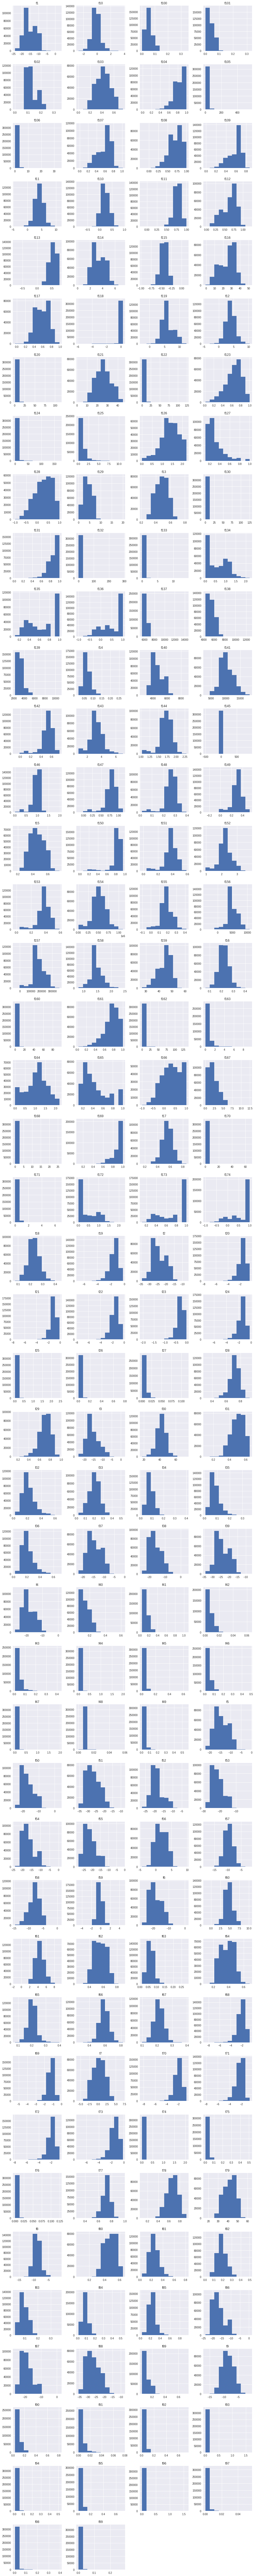

In [29]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

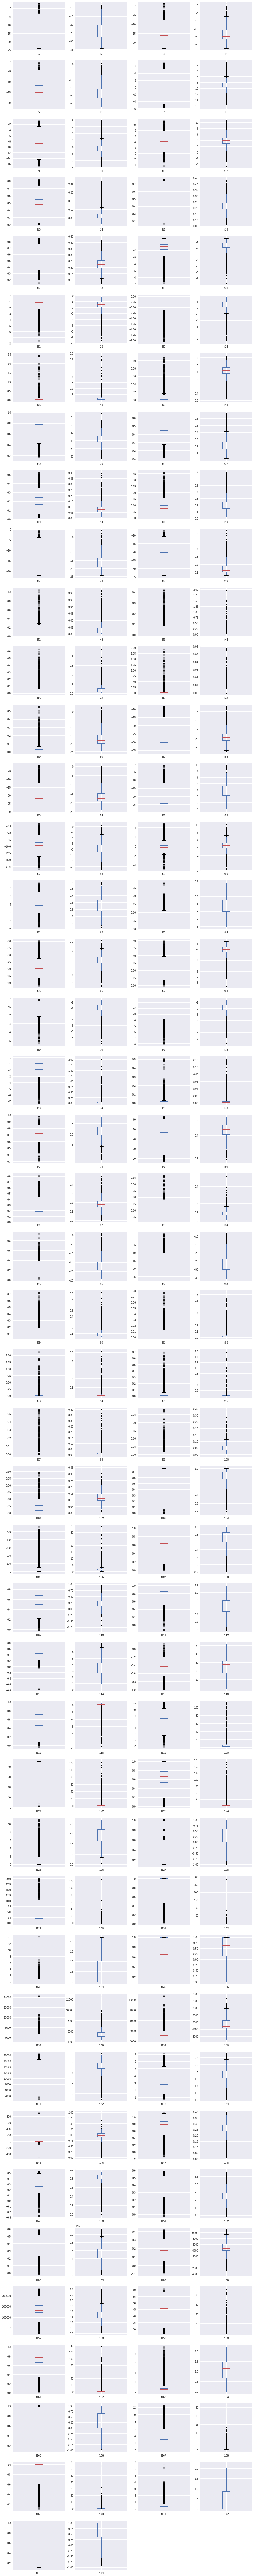

In [30]:
# Box and Whisker plot for each attribute
X_original.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

In [31]:
# # Correlation matrix
# fig = plt.figure(figsize=(16,12))
# ax = fig.add_subplot(111)
# correlations = X_original.corr(method='pearson')
# cax = ax.matshow(correlations, vmin=-1, vmax=1)
# fig.colorbar(cax)
# plt.show()

In [32]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [33]:
if notifyStatus: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [34]:
# Split the data further into training and test datasets
# X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=test_set_size, stratify=y_original, random_state=seedNum)
X_train_val, X_test_df, y_train_val, y_test_df = train_test_split(X_original, y_original, test_size=test_set_size, stratify=y_original, random_state=seedNum)
X_train_df, X_validation_df, y_train_df, y_validation_df = train_test_split(X_train_val, y_train_val, test_size=val_set_size, stratify=y_train_val, random_state=seedNum)
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_validation_df.shape: {} y_validation_df.shape: {}".format(X_validation_df.shape, y_validation_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (195500, 174) y_train_df.shape: (195500,)
X_validation_df.shape: (65167, 174) y_validation_df.shape: (65167,)
X_test_df.shape: (65167, 174) y_test_df.shape: (65167,)


### 3.b) Feature Scaling and Data Pre-Processing

In [35]:
# Gather a list of features for applying the data pre-processing
columns_to_scale = X_train_df.columns[X_train_df.dtypes == 'float64'].tolist()
print('Columns to scale are:', columns_to_scale)

Columns to scale are: ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136

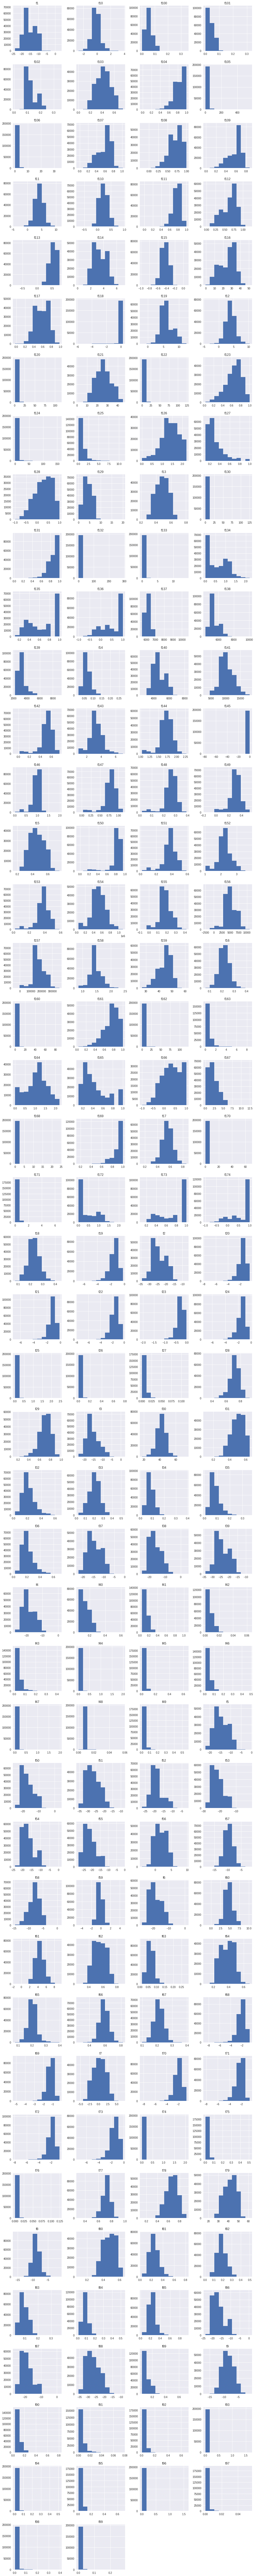

In [36]:
# Histograms for each attribute before pre-processing
X_train_df[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

In [37]:
# Apply feature scaling and transformation to the training dataset
scaler = preprocessing.StandardScaler()
X_train_df[columns_to_scale] = scaler.fit_transform(X_train_df[columns_to_scale])
print(X_train_df.head())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

              f1        f2        f3  ...      f172      f173      f174
236118 -0.339406 -0.230085 -0.584942  ... -0.839844  0.859186  0.704999
40667   1.580330  2.254449  1.795232  ... -0.839844  0.859186  0.704999
277573 -0.642567 -0.396346 -0.321902  ...  0.585284 -0.493592 -1.681100
271084 -1.070761 -1.045847 -0.551297  ... -0.839844  0.859186  0.704999
263327 -1.156971 -0.997498 -0.381545  ... -0.839844  0.859186  0.704999

[5 rows x 174 columns]


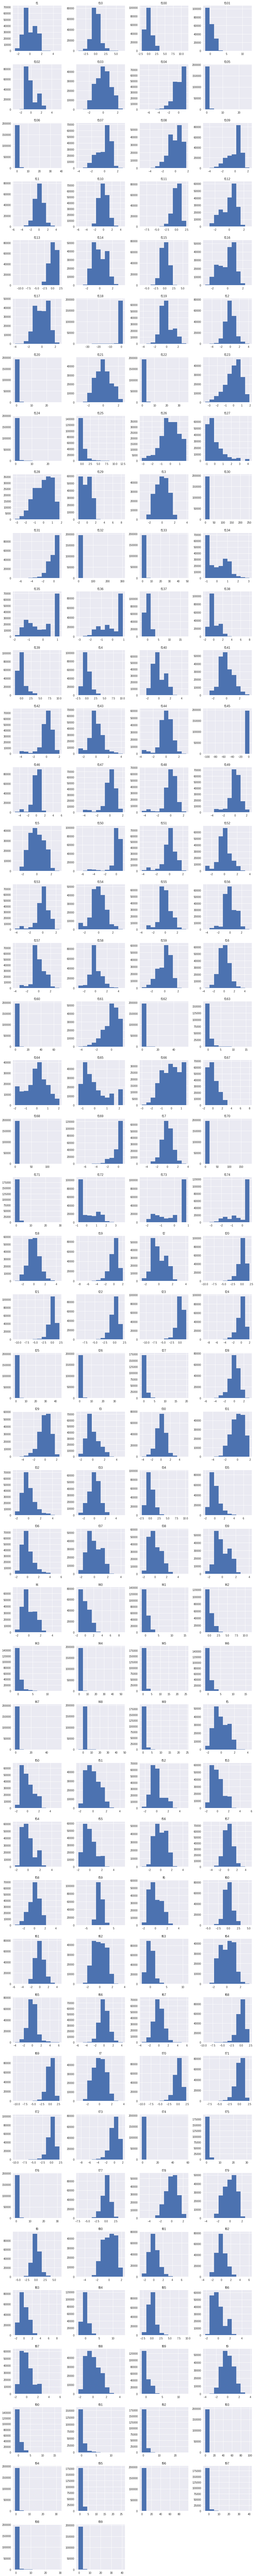

In [38]:
# Histograms for each attribute after pre-processing
X_train_df[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

### 3.c) Training Data Balancing

In [39]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [40]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [41]:
# Finalize the training and testing datasets for the modeling activities
X_train = X_train_df.to_numpy()
y_train = y_train_df.ravel()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))

X_train.shape: (195500, 174) y_train.shape: (195500,)


In [42]:
if notifyStatus: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [43]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [44]:
# Set up Algorithms Spot-Checking Array
startTimeTraining = datetime.now()
startTimeModule = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('XGB', XGBClassifier(random_state=seedNum, n_jobs=n_jobs, objective='multi:softmax', num_class=7, tree_method='gpu_hist')))

In [45]:
# Generate model in turn
for name, model in train_models:
	if notifyStatus: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=n_jobs, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - startTimeModule), '\n')
	if notifyStatus: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - startTimeTraining))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGB: 0.989995 (0.000067)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=7, objective='multi:softmax',
              random_state=888, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, tree_method='gpu_hist',
              verbosity=1)
Model training time: 0:00:29.658034 

Average metrics (accuracy) from all models: 0.9899948849104859
Total training time for all models: 0:00:29.682873


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.7s finished


### 4.b) Spot-checking baseline algorithms

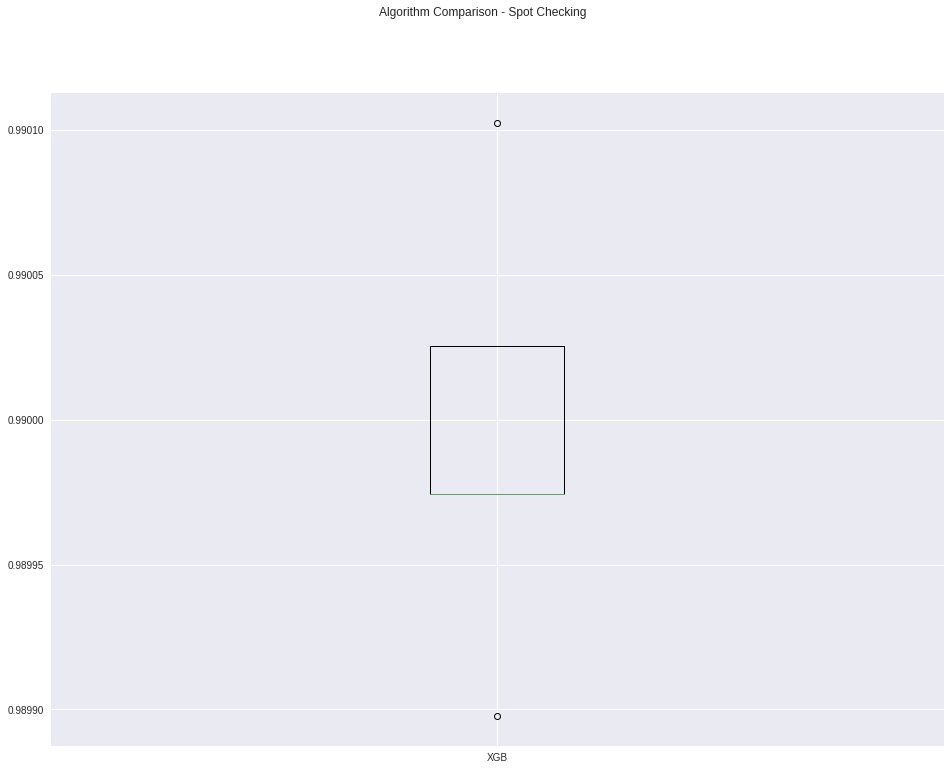

In [46]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [47]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Fine-tune and Improve Models

In [48]:
if notifyStatus: status_notify("Task 5 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Algorithm Tuning

In [49]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [50]:
# Tuning XGBoost n_estimators parameter
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm tuning iteration #1 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBClassifier(random_state=seedNum, n_jobs=n_jobs, objective='multi:softmax', num_class=7, tree_method='gpu_hist')
tune_model_names.append('XGB_1')
paramGrid1 = dict(n_estimators=range(1000,2001,100))

kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold, verbose=2)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm tuning iteration #1 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ n_estimators=1000, total=  48.6s
[CV] n_estimators=1000 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.6s remaining:    0.0s


[CV] ................................ n_estimators=1000, total=  50.5s
[CV] n_estimators=1000 ...............................................
[CV] ................................ n_estimators=1000, total=  47.6s
[CV] n_estimators=1000 ...............................................
[CV] ................................ n_estimators=1000, total=  48.6s
[CV] n_estimators=1000 ...............................................
[CV] ................................ n_estimators=1000, total=  49.8s
[CV] n_estimators=1100 ...............................................
[CV] ................................ n_estimators=1100, total=  53.3s
[CV] n_estimators=1100 ...............................................
[CV] ................................ n_estimators=1100, total=  55.3s
[CV] n_estimators=1100 ...............................................
[CV] ................................ n_estimators=1100, total=  52.0s
[CV] n_estimators=1100 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed: 66.0min finished


Best: 0.997893 using {'n_estimators': 2000}
0.997565 (0.000298) with: {'n_estimators': 1000}
0.997616 (0.000290) with: {'n_estimators': 1100}
0.997652 (0.000243) with: {'n_estimators': 1200}
0.997714 (0.000249) with: {'n_estimators': 1300}
0.997760 (0.000261) with: {'n_estimators': 1400}
0.997780 (0.000251) with: {'n_estimators': 1500}
0.997831 (0.000246) with: {'n_estimators': 1600}
0.997836 (0.000259) with: {'n_estimators': 1700}
0.997862 (0.000258) with: {'n_estimators': 1800}
0.997857 (0.000263) with: {'n_estimators': 1900}
0.997893 (0.000258) with: {'n_estimators': 2000}
Model training time: 1:07:50.091901


In [51]:
# Tuning XGBoost max_depth and min_child_weight parameters
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm tuning iteration #2 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBClassifier(n_estimators=2000, random_state=seedNum, n_jobs=n_jobs, objective='multi:softmax', num_class=7, tree_method='gpu_hist')
tune_model_names.append('XGB_2')
paramGrid1 = dict(max_depth=np.array([3,6,9]), min_child_weight=np.array([1,2,3]))

kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold, verbose=2)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm tuning iteration #2 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=3, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. max_depth=3, min_child_weight=1, total= 1.6min
[CV] max_depth=3, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV] .................. max_depth=3, min_child_weight=1, total= 1.6min
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total= 1.5min
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total= 1.6min
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total= 1.6min
[CV] max_depth=3, min_child_weight=2 .................................
[CV] .................. max_depth=3, min_child_weight=2, total= 1.5min
[CV] max_depth=3, min_child_weight=2 .................................
[CV] .................. max_depth=3, min_child_weight=2, total= 1.6min
[CV] max_depth=3, min_child_weight=2 .................................
[CV] .................. max_depth=3, min_child_weight=2, total= 1.5min
[CV] max_depth=3, min_child_weight=2 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 73.2min finished


Best: 0.997893 using {'max_depth': 3, 'min_child_weight': 1}
0.997893 (0.000258) with: {'max_depth': 3, 'min_child_weight': 1}
0.997780 (0.000221) with: {'max_depth': 3, 'min_child_weight': 2}
0.997754 (0.000187) with: {'max_depth': 3, 'min_child_weight': 3}
0.997831 (0.000192) with: {'max_depth': 6, 'min_child_weight': 1}
0.997775 (0.000203) with: {'max_depth': 6, 'min_child_weight': 2}
0.997714 (0.000153) with: {'max_depth': 6, 'min_child_weight': 3}
0.997627 (0.000201) with: {'max_depth': 9, 'min_child_weight': 1}
0.997560 (0.000201) with: {'max_depth': 9, 'min_child_weight': 2}
0.997575 (0.000226) with: {'max_depth': 9, 'min_child_weight': 3}
Model training time: 1:14:59.319943


In [52]:
# Tuning XGBoost subsample and colsample_bytree parameters
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm tuning iteration #3 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBClassifier(n_estimators=2000, max_depth=3, min_child_weight=1, random_state=seedNum, n_jobs=n_jobs, objective='multi:softmax', num_class=7, tree_method='gpu_hist')
tune_model_names.append('XGB_3')
paramGrid1 = dict(subsample=np.array([0.7,0.8,0.9,1.0]), colsample_bytree=np.array([0.7,0.8,0.9,1.0]))

kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold, verbose=2)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm tuning iteration #3 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] colsample_bytree=0.7, subsample=0.7 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............. colsample_bytree=0.7, subsample=0.7, total= 1.6min
[CV] colsample_bytree=0.7, subsample=0.7 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV] .............. colsample_bytree=0.7, subsample=0.7, total= 1.6min
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV] .............. colsample_bytree=0.7, subsample=0.7, total= 1.5min
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV] .............. colsample_bytree=0.7, subsample=0.7, total= 1.6min
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV] .............. colsample_bytree=0.7, subsample=0.7, total= 1.6min
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV] .............. colsample_bytree=0.7, subsample=0.8, total= 1.6min
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV] .............. colsample_bytree=0.7, subsample=0.8, total= 1.6min
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV] .............. colsample_bytree=0.7, subsample=0.8, total= 1.5min
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 126.6min finished


Best: 0.997974 using {'colsample_bytree': 0.7, 'subsample': 0.9}
0.997908 (0.000185) with: {'colsample_bytree': 0.7, 'subsample': 0.7}
0.997887 (0.000224) with: {'colsample_bytree': 0.7, 'subsample': 0.8}
0.997974 (0.000212) with: {'colsample_bytree': 0.7, 'subsample': 0.9}
0.997862 (0.000168) with: {'colsample_bytree': 0.7, 'subsample': 1.0}
0.997923 (0.000117) with: {'colsample_bytree': 0.8, 'subsample': 0.7}
0.997903 (0.000167) with: {'colsample_bytree': 0.8, 'subsample': 0.8}
0.997954 (0.000212) with: {'colsample_bytree': 0.8, 'subsample': 0.9}
0.997872 (0.000234) with: {'colsample_bytree': 0.8, 'subsample': 1.0}
0.997913 (0.000187) with: {'colsample_bytree': 0.9, 'subsample': 0.7}
0.997939 (0.000218) with: {'colsample_bytree': 0.9, 'subsample': 0.8}
0.997913 (0.000232) with: {'colsample_bytree': 0.9, 'subsample': 0.9}
0.997893 (0.000193) with: {'colsample_bytree': 0.9, 'subsample': 1.0}
0.997934 (0.000149) with: {'colsample_bytree': 1.0, 'subsample': 0.7}
0.997908 (0.000208) with:

### 5.b) Compare Algorithms After Tuning

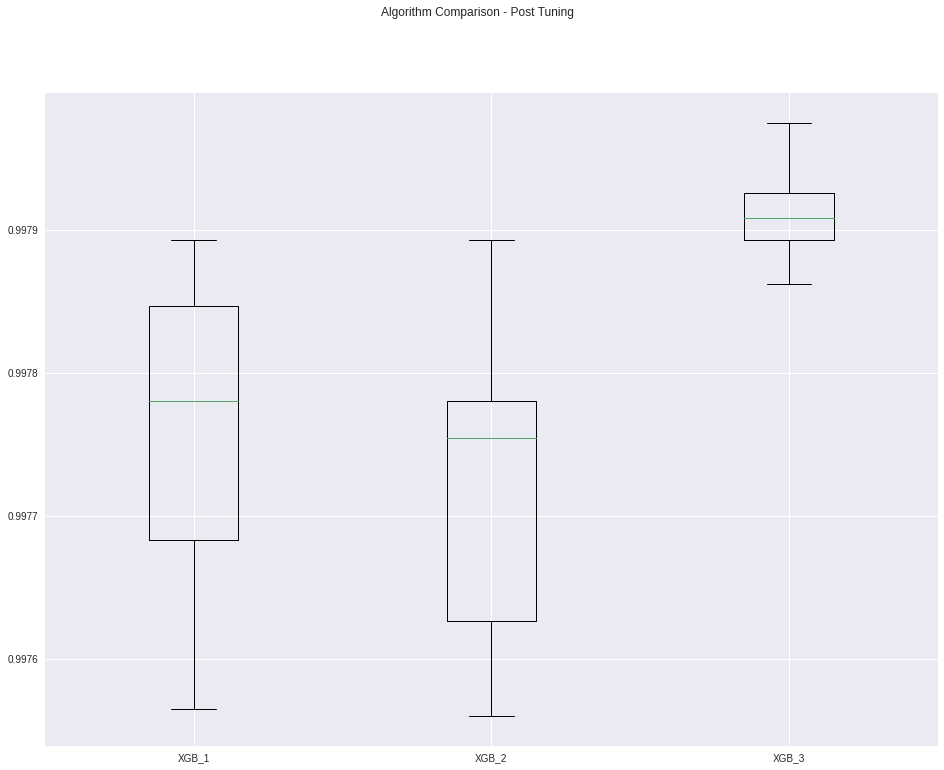

In [54]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

### 5.c) Measure and Validate Models' Effectiveness

In [55]:
# Apply feature scaling and transformation to the validation dataset
X_validation_df[columns_to_scale] = scaler.transform(X_validation_df[columns_to_scale])
print(X_validation_df.head())

              f1        f2        f3  ...      f172      f173      f174
193812 -0.954578 -0.827538 -1.559107  ... -0.839844  0.859186  0.704999
270137  1.010547  0.911538  0.562034  ...  0.929091 -0.944530 -1.816800
20171   1.780211  1.551419  2.443901  ... -0.839844  0.859186  0.704999
263306 -1.427019 -1.202734 -0.396532  ...  1.250096 -1.034710 -0.658493
234378 -0.237496 -0.239952 -0.332913  ... -0.839844  0.859186  0.704999

[5 rows x 174 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [56]:
# Display information about the validation dataset for spot-checking
X_validation = X_validation_df.to_numpy()
y_validation = y_validation_df.ravel()
print("X_validation.shape: {} y_validation.shape: {}".format(X_validation.shape, y_validation.shape))

X_validation.shape: (65167, 174) y_validation.shape: (65167,)


In [57]:
validation_model = XGBClassifier(n_estimators=2000, max_depth=3, min_child_weight=1, subsample=0.9, colsample_bytree=0.7, random_state=seedNum, n_jobs=n_jobs, objective='multi:softmax', num_class=7, tree_method='gpu_hist')
validation_model.fit(X_train, y_train)
predictions = validation_model.predict(X_validation)
print('Accuracy Score:', accuracy_score(y_validation, predictions))
print(confusion_matrix(y_validation, predictions),'\n')
print(classification_report(y_validation, predictions))
print(validation_model)

Accuracy Score: 0.9980971964337778
[[ 7814     0     2    11     0     0     5]
 [    2   716     0     1     0     0     0]
 [    1     0 15122     8     0     4     0]
 [    4     0     1 14794     9     6     0]
 [    0     0     5    10  9391    16     2]
 [    1     0     2     7    17 16985     3]
 [    2     0     1     0     0     4   221]] 

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      7832
           2       1.00      1.00      1.00       719
           3       1.00      1.00      1.00     15135
           4       1.00      1.00      1.00     14814
           5       1.00      1.00      1.00      9424
           6       1.00      1.00      1.00     17015
           7       0.96      0.97      0.96       228

    accuracy                           1.00     65167
   macro avg       0.99      0.99      0.99     65167
weighted avg       1.00      1.00      1.00     65167

XGBClassifier(base_score=0.5, booster='gbtree', co

In [58]:
if notifyStatus: status_notify("Task 5 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 6 - Finalize Model and Present Analysis

In [59]:
if notifyStatus: status_notify("Task 6 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Measure predictions from the test dataset

In [60]:
# Apply feature scaling and transformation to the test dataset
X_test_df[columns_to_scale] = scaler.transform(X_test_df[columns_to_scale])
print(X_test_df.head())

              f1        f2        f3  ...      f172      f173      f174
75386   1.279452  1.549938  0.329275  ... -0.839844  0.859186  0.704999
315080 -0.345972 -0.563346 -0.285810  ... -0.112773  0.137707  0.704999
163561 -1.398758 -1.203227 -0.845229  ... -0.839844  0.859186  0.704999
312398 -0.420763 -0.279914 -0.640303  ...  0.264237 -0.403412 -0.355490
18169   0.889225  1.031423  1.422419  ... -0.839844  0.859186  0.704999

[5 rows x 174 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [61]:
# Display information about the test dataset for spot-checking
X_test = X_test_df.to_numpy()
y_test = y_test_df.ravel()
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_test.shape: (65167, 174) y_test.shape: (65167,)


In [63]:
# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
X_train_val = np.vstack((X_train, X_validation))
y_train_val = np.concatenate((y_train, y_validation))
print("X_train_val.shape: {} y_train_val.shape: {}".format(X_train_val.shape, y_train_val.shape))

X_train_val.shape: (260667, 174) y_train_val.shape: (260667,)


In [64]:
test_model = XGBClassifier(n_estimators=2000, max_depth=3, min_child_weight=1, subsample=0.9, colsample_bytree=0.7, random_state=seedNum, n_jobs=n_jobs, objective='multi:softmax', num_class=7, tree_method='gpu_hist')
test_model.fit(X_train_val, y_train_val)
predictions = test_model.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions),'\n')
print(classification_report(y_test, predictions))
print(test_model)

Accuracy Score: 0.9984041002347814
[[ 7818     1     0     8     1     2     2]
 [    0   718     0     2     0     0     0]
 [    0     0 15123     5     2     4     1]
 [    2     0     4 14795     5     7     0]
 [    0     0     2    12  9384    23     2]
 [    0     0     2     2    10 16998     3]
 [    1     0     1     0     0     0   227]] 

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      7832
           2       1.00      1.00      1.00       720
           3       1.00      1.00      1.00     15135
           4       1.00      1.00      1.00     14813
           5       1.00      1.00      1.00      9423
           6       1.00      1.00      1.00     17015
           7       0.97      0.99      0.98       229

    accuracy                           1.00     65167
   macro avg       0.99      1.00      1.00     65167
weighted avg       1.00      1.00      1.00     65167

XGBClassifier(base_score=0.5, booster='gbtree', co

### 6.b) Create a standalone model using all available data

In [65]:
# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
# X_final = np.vstack((X_train, X_validation, X_test))
# y_final = np.concatenate((y_train, y_validation, y_test))
# print("X_final.shape: {} y_final.shape: {}\n".format(X_final.shape, y_final.shape))
# final_model = XGBClassifier(n_estimators=900, max_depth=6, min_child_weight=1, subsample=0.8, colsample_bytree=0.8, random_state=seedNum, n_jobs=n_jobs, objective='multi:softmax', num_class=7, tree_method='gpu_hist')
# final_model.fit(X_final, y_final)
# print(final_model)

### 6.c) Save the final model for later use

In [66]:
# modelName = 'FinalModel_MultiClass.sav'
# dump(final_model, modelName)

In [67]:
if notifyStatus: status_notify("Task 6 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [68]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 5:29:59.272843
